In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import math

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### change cab_type to binary value 

In [4]:
train['cab_type'] = train['cab_type'].replace({'Uber':1,'Lyft':0})

In [7]:
train.head(3)

,distance,cab_type,time_stamp,price,surge_multiplier,temp_source,clouds_source,pressure_source,rain_source,humidity_source,...,nm_Lux,nm_Lux Black,nm_Lux Black XL,nm_Lyft,nm_Lyft XL,nm_Shared,nm_UberPool,nm_UberX,nm_UberXL,nm_WAV
0,3.44,1,1543244710344,17.0,1.0,39.394092,0.677495,1008.438031,0.008310,0.755468,...,0,0,0,0,0,0,0,0,0,1
1,2.49,0,1543616288459,16.5,1.0,39.047285,0.677801,1008.448356,0.008297,0.765048,...,1,0,0,0,0,0,0,0,0,0
2,1.11,1,1543411028318,26.0,1.0,39.090841,0.676730,1008.441912,0.008644,0.764054,...,0,0,0,0,0,0,0,0,0,0


## WEATHER EDA
#### create indicator value for strength of wind/rain/humidity

## WIND

In [19]:
wd25, wd50, wd75 = train['wind_destination'].quantile([0.25, 0.5, 0.75])
ws25, ws50, ws75 = train['wind_source'].quantile([0.25, 0.5, 0.75])

In [21]:
# wind destination 
train.loc[train['wind_destination'] < wd25, 'wind_d_strength'] = 1
train.loc[((train['wind_destination'] < wd50) & (train['wind_destination'] >= wd25)), 'wind_d_strength'] = 2
train.loc[((train['wind_destination'] < wd75) & (train['wind_destination'] >= wd50)), 'wind_d_strength'] = 3
train.loc[train['wind_destination'] >= wd75, 'wind_d_strength'] = 4

In [35]:
# wind source 
train.loc[train['wind_source'] < ws25, 'wind_s_strength'] = 1
train.loc[((train['wind_source'] < ws50) & (train['wind_source'] >= ws25)), 'wind_s_strength'] = 2
train.loc[((train['wind_source'] < ws75) & (train['wind_source'] >= ws50)), 'wind_s_strength'] = 3
train.loc[train['wind_source'] >= ws75, 'wind_s_strength'] = 4

<AxesSubplot:xlabel='wind_s_strength', ylabel='price'>

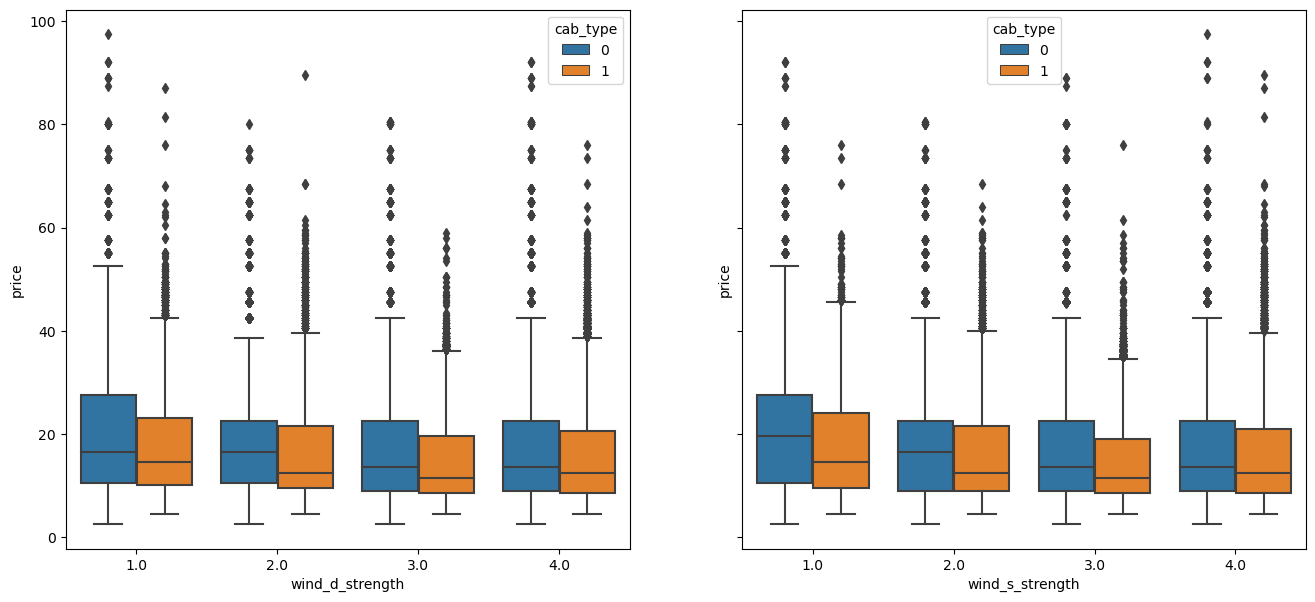

In [69]:
fig, ax =plt.subplots(1,2, figsize=(16, 7))
sns.boxplot(ax=ax[0], data = train, x = 'wind_d_strength', y = 'price', hue = 'cab_type')
sns.boxplot(ax=ax[1], data = train, x = 'wind_s_strength', y = 'price', hue = 'cab_type')

#### conclusion: prices of ubers were marginally higher for when wind_strength was 1 (its lowest), however, it does appear that in general at every rain strength, cab_type 1 (Uber) offers a lower price

## RAIN

In [30]:
rd25, rd50, rd75 = train['rain_destination'].quantile([0.25, 0.5, 0.75])
rs25, rs50, rs75 = train['rain_source'].quantile([0.25, 0.5, 0.75])

In [33]:
# rain destination 
train.loc[train['rain_destination'] < rd25, 'rain_d_strength'] = 1
train.loc[((train['rain_destination'] < rd50) & (train['rain_destination'] >= rd25)), 'rain_d_strength'] = 2
train.loc[((train['rain_destination'] < rd75) & (train['rain_destination'] >= rd50)), 'rain_d_strength'] = 3
train.loc[train['rain_destination'] >= rd75, 'rain_d_strength'] = 4

In [38]:
# rain source 
train.loc[train['rain_source'] < rs25, 'rain_s_strength'] = 1
train.loc[((train['rain_source'] < rs50) & (train['rain_source'] >= rs25)), 'rain_s_strength'] = 2
train.loc[((train['rain_source'] < rs75) & (train['rain_source'] >= rs50)), 'rain_s_strength'] = 3
train.loc[train['rain_source'] >= rs75, 'rain_s_strength'] = 4

<AxesSubplot:xlabel='rain_s_strength', ylabel='price'>

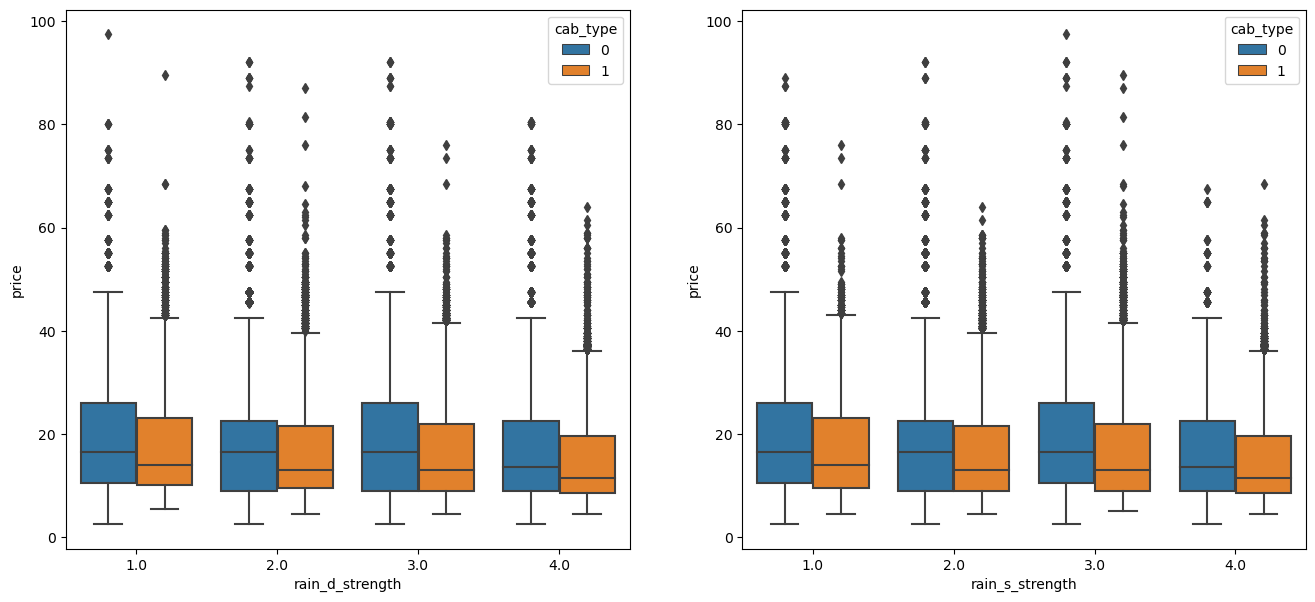

In [76]:
fig, ax =plt.subplots(1,2, figsize=(16, 7))
sns.boxplot(ax = ax[0], data = train, x = 'rain_d_strength', y = 'price', hue = 'cab_type')
sns.boxplot(ax = ax[1], data = train, x = 'rain_s_strength', y = 'price', hue = 'cab_type')

#### remove outliers

In [47]:
rainnooutliers = train[train['price'] <45] # super approximate removal of outliers

rd25, rd50, rd75 = rainnooutliers['rain_destination'].quantile([0.25, 0.5, 0.75])
rs25, rs50, rs75 = rainnooutliers['rain_source'].quantile([0.25, 0.5, 0.75])

# rain destination 
rainnooutliers.loc[rainnooutliers['rain_destination'] < rd25, 'rain_d_strength'] = 1
rainnooutliers.loc[((rainnooutliers['rain_destination'] < rd50) & (rainnooutliers['rain_destination'] >= rd25)), 'rain_d_strength'] = 2
rainnooutliers.loc[((rainnooutliers['rain_destination'] < rd75) & (rainnooutliers['rain_destination'] >= rd50)), 'rain_d_strength'] = 3
rainnooutliers.loc[rainnooutliers['rain_destination'] >= rd75, 'rain_d_strength'] = 4


<AxesSubplot:xlabel='rain_s_strength', ylabel='price'>

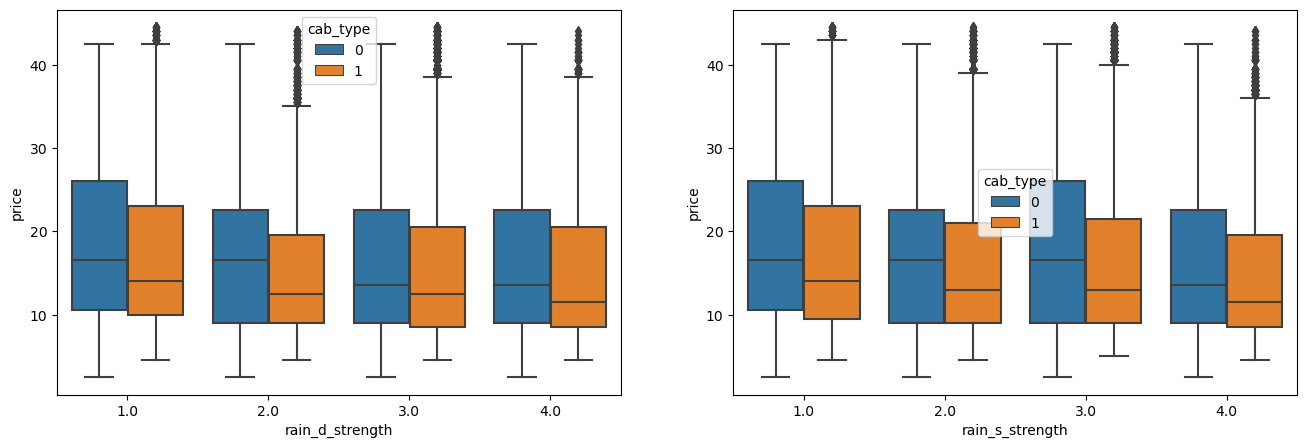

In [75]:
fig, ax =plt.subplots(1,2, figsize=(16, 5))
sns.boxplot(ax=ax[0],data = rainnooutliers, x = 'rain_d_strength', y = 'price', hue = 'cab_type')
sns.boxplot(ax=ax[1],data = rainnooutliers, x = 'rain_s_strength', y = 'price', hue = 'cab_type')


#### conclusion: doesn't seem to be a huge correlation between rain strength and price of ride. however, it does appear that in general at every rain strength, cab_type 1 (Uber) offers a lower price

## HUMIDITY

In [55]:
hd25, hd50, hd75 = train['humidity_destination'].quantile([0.25, 0.5, 0.75])
hs25, hs50, hs75 = train['humidity_source'].quantile([0.25, 0.5, 0.75])

In [77]:
# humidity destination 
train.loc[train['humidity_destination'] < hd25, 'humidity_d_strength'] = 1
train.loc[((train['humidity_destination'] < hd50) & (train['humidity_destination'] >= hd25)), 'humidity_d_strength'] = 2
train.loc[((train['humidity_destination'] < hd75) & (train['humidity_destination'] >= hd50)), 'humidity_d_strength'] = 3
train.loc[train['humidity_destination'] >= hd75, 'humidity_d_strength'] = 4

In [78]:
# humidity source 
train.loc[train['humidity_source'] < hd25, 'humidity_s_strength'] = 1
train.loc[((train['humidity_source'] < hd50) & (train['humidity_source'] >= hd25)), 'humidity_s_strength'] = 2
train.loc[((train['humidity_source'] < hd75) & (train['humidity_source'] >= hd50)), 'humidity_s_strength'] = 3
train.loc[train['humidity_source'] >= hd75, 'humidity_s_strength'] = 4

<AxesSubplot:xlabel='humidity_s_strength', ylabel='price'>

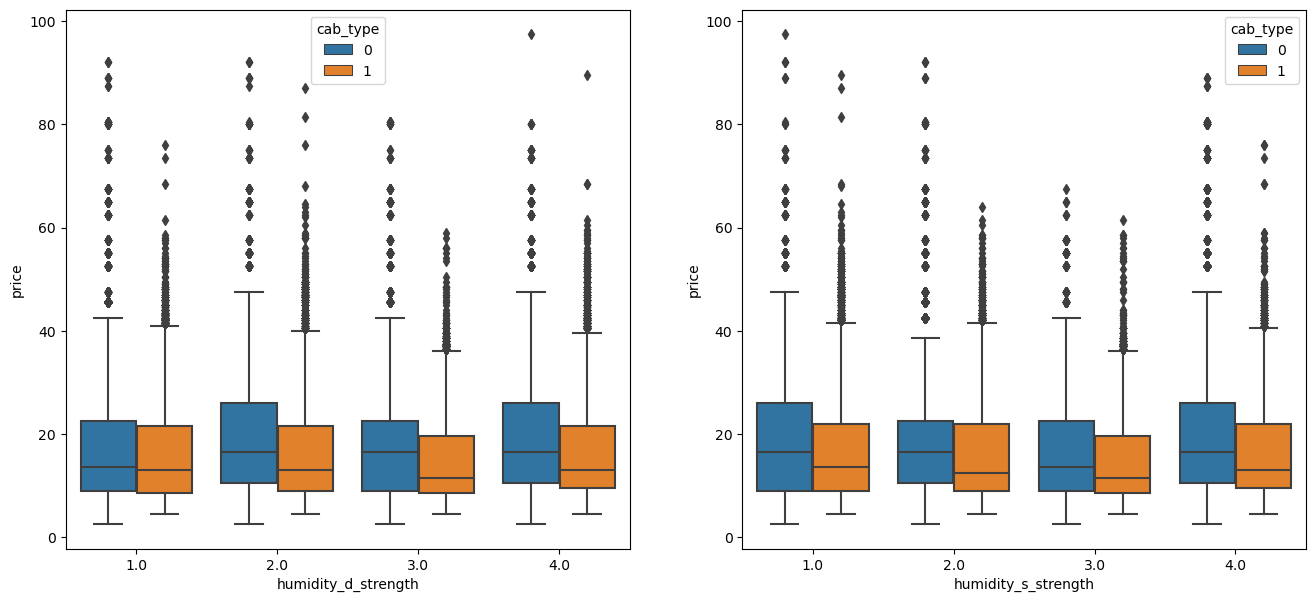

In [79]:
fig, ax =plt.subplots(1,2, figsize=(16, 7))
sns.boxplot(ax = ax[0], data = train, x = 'humidity_d_strength', y = 'price', hue = 'cab_type')
sns.boxplot(ax = ax[1], data = train, x = 'humidity_s_strength', y = 'price', hue = 'cab_type')

#### 3 levels of strength...

In [116]:
# humidity source 
train.loc[train['humidity_source'] < hs25, 'humidity_s_strength_3'] = 1
train.loc[((train['humidity_source'] < hs75) & (train['humidity_source'] >= hs25)), 'humidity_s_strength_3'] = 2
train.loc[train['humidity_source'] >= hs75, 'humidity_s_strength_3'] = 3

<AxesSubplot:xlabel='humidity_s_strength_3', ylabel='price'>

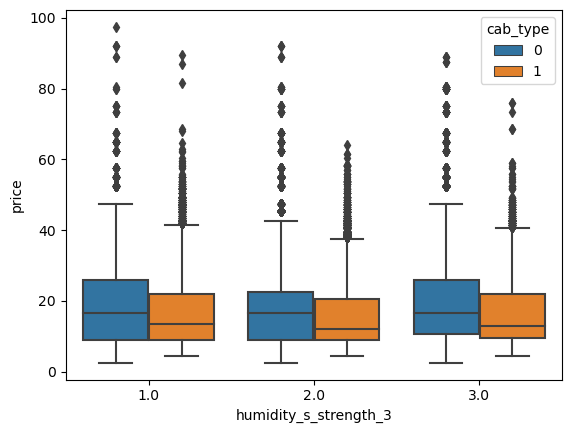

In [117]:
sns.boxplot(data = train, x = 'humidity_s_strength_3', y = 'price', hue = 'cab_type')

#### conclusion: no strong correlation, could keep trying dif strength categories (not just sticking to 25, 50, 75 percentile. but doesn't seem like strong relationship. but again, uber is in general priced lower

## note: humidity and rain are probably closely related, look into when building model

## LOCATION EDA

In [113]:
locationdf = pd.DataFrame(train.iloc[:,17:41].sum()).reset_index()
locationdf.columns = ['location', 'count']
locationdf.sort_values(by = 'count', ascending = False)

,location,count
16,src_Financial District,38002
4,desti_Financial District,37967
20,src_Northeastern University,37351
3,desti_Fenway,37319
22,src_Theatre District,37312
2,desti_Boston University,37307
18,src_North End,37280
5,desti_Haymarket Square,37264
15,src_Fenway,37256
8,desti_Northeastern University,37231


<AxesSubplot:xlabel='location', ylabel='count'>

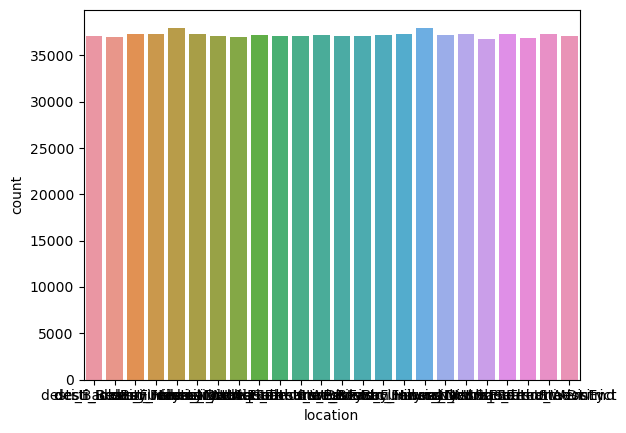

In [110]:
sns.barplot(data = locationdf, x = 'location', y = 'count')

#### conclusion/thoughts: there aren't super big fluctuations between number of rides to/from each of these places. The financial district has the highest amount of rides BOTH to and from, followed closely by src_Northeastern University (which makes sense since it's a school). I'd imagine that these peaks would be a lot more pronounced if we had data that had been collected over a larger amount of time

#### could make indicator column -- 1 for popular location (financial district, schools), 0 otherwise. but again, the differences aren't super pronounced so i don't think it would help the model that much

## creating indicator column for "bad weather" 
#### combines wind, rain, humidity

In [142]:
train.loc[(train['wind_s_strength'] == 4) & (train['rain_s_strength'] == 4), 'bad_weather'] = 1


In [152]:
train.fillna(0, inplace = True)
train

,distance,cab_type,time_stamp,price,surge_multiplier,temp_source,clouds_source,pressure_source,rain_source,humidity_source,...,nm_WAV,wind_strength,wind_d_strength,wind_s_strength,rain_d_strength,rain_s_strength,humidity_d_strength,humidity_s_strength,humidity_s_strength_3,bad_weather
0,3.44,1,1543244710344,17.0,1.0,39.394092,0.677495,1008.438031,0.008310,0.755468,...,1,2.0,2.0,4.0,2.0,2.0,2.0,1.0,1.0,0.0
1,2.49,0,1543616288459,16.5,1.0,39.047285,0.677801,1008.448356,0.008297,0.765048,...,0,2.0,2.0,2.0,1.0,2.0,4.0,3.0,2.0,0.0
2,1.11,1,1543411028318,26.0,1.0,39.090841,0.676730,1008.441912,0.008644,0.764054,...,0,2.0,2.0,4.0,4.0,4.0,4.0,2.0,2.0,1.0
3,2.46,1,1544875808678,28.5,1.0,38.964379,0.679866,1008.453289,0.007343,0.767266,...,0,2.0,2.0,1.0,2.0,1.0,3.0,4.0,3.0,0.0
4,0.54,1,1544904007067,10.5,1.0,39.394092,0.677495,1008.438031,0.008310,0.755468,...,1,4.0,4.0,4.0,3.0,2.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446578,2.67,0,1543460708150,16.5,1.0,39.082122,0.678432,1008.447820,0.007925,0.764073,...,0,4.0,4.0,2.0,4.0,2.0,2.0,2.0,2.0,0.0
446579,2.84,0,1544912112411,22.5,1.0,38.964379,0.679866,1008.453289,0.007343,0.767266,...,0,2.0,2.0,1.0,4.0,1.0,4.0,4.0,3.0,0.0
446580,0.61,1,1544773509534,7.5,1.0,39.067897,0.676711,1008.445239,0.008660,0.764837,...,0,2.0,2.0,3.0,4.0,4.0,4.0,3.0,2.0,0.0
446581,3.07,1,1543449821410,10.5,1.0,38.964379,0.679866,1008.453289,0.007343,0.767266,...,0,3.0,3.0,1.0,4.0,1.0,3.0,4.0,3.0,0.0


<AxesSubplot:xlabel='bad_weather', ylabel='price'>

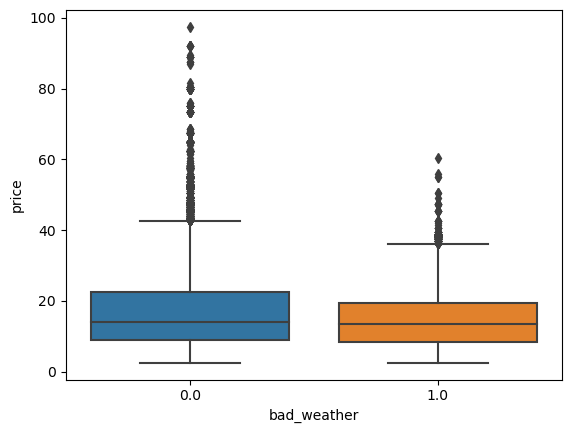

In [157]:
sns.boxplot(data = train, x = 'bad_weather', y = 'price')

<AxesSubplot:xlabel='distance', ylabel='price'>

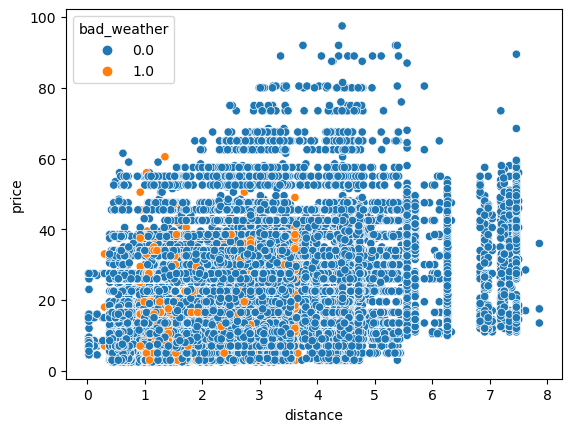

In [154]:
sns.scatterplot(data = train, x = 'distance', y = 'price', hue = 'bad_weather')

#### bad weather genuinely doesn't seem to affect price...... BUT it appears that most of the rides taken during bad weather happen for shorter distances --- might just be a convenience thing. and could explain why it doens't corerspond with higher prices bc distance is the largest determiner of price and most rides called during bad weather are shorter rides

#### !!!!!!

### only looking at shorter rides - still no takeaway. 

In [160]:
shorterrides = train[train['distance'] < 4]

<AxesSubplot:xlabel='bad_weather', ylabel='price'>

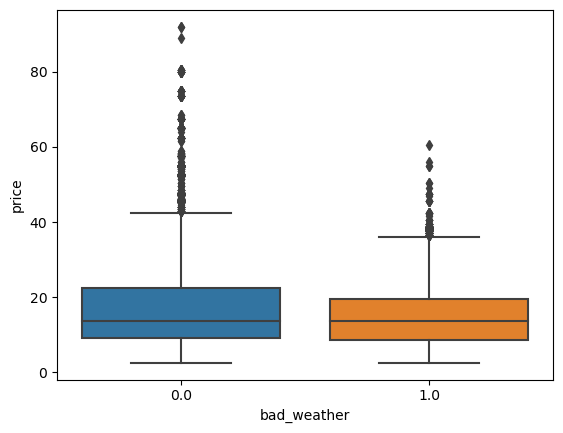

In [158]:
sns.boxplot(data = shorterrides, x = 'bad_weather', y = 'price')

In [177]:
badweather = train[train['bad_weather'] == 1]
uber = train[train['cab_type']==1]

<AxesSubplot:xlabel='distance', ylabel='price'>

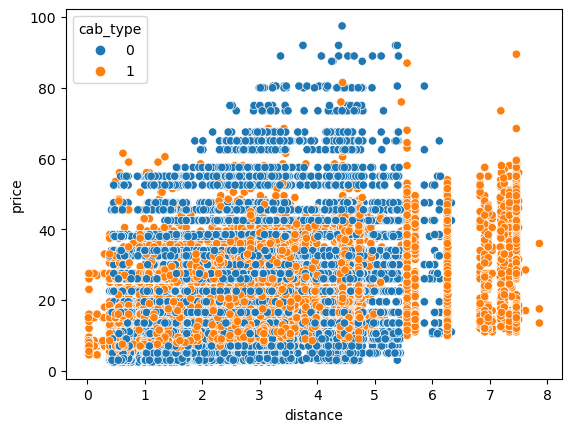

In [181]:
sns.scatterplot(data = train, x = 'distance', y = 'price', hue = 'cab_type')

<AxesSubplot:xlabel='distance', ylabel='price'>

/Users/cindywu/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


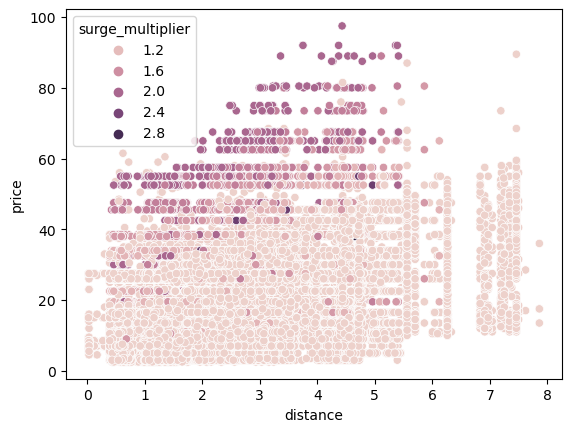

In [182]:
sns.scatterplot(data = train, x = 'distance', y = 'price', hue = 'surge_multiplier')

#### weather doesn't play super big role in determining price but probably just bc surge multiplier covers it -- demand goes up when weather is bad and that's reflected in the surge multiplier